In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import ascii, fits

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

In [5]:
ra0_list = np.load("tables/testing-on-mocks/ra0_list.npy")
dec0_list = np.load("tables/testing-on-mocks/dec0_list.npy")
z_cluster_list = np.load("tables/testing-on-mocks/z_cluster_list.npy")
m200_list = np.load("tables/testing-on-mocks/m200_list.npy")
r200_mpc_list = np.load("tables/testing-on-mocks/r200_mpc_list.npy")
r200_deg_list = np.load("tables/testing-on-mocks/r200_deg_list.npy")
cut_zp_list = np.load("tables/testing-on-mocks/cut_zp_list.npy")
w1_list = np.load("tables/testing-on-mocks/w1_list.npy")
w2_list = np.load("tables/testing-on-mocks/w2_list.npy")
alpha_list = np.load("tables/testing-on-mocks/alpha_list.npy")
cut_R_list = np.load("tables/testing-on-mocks/cut_R_list.npy")
c_zp_max_list = np.load("tables/testing-on-mocks/c_zp_max_list.npy")
p_zp_max_list = np.load("tables/testing-on-mocks/p_zp_max_list.npy")
c_R_max_list = np.load("tables/testing-on-mocks/c_R_max_list.npy")
p_R_max_list = np.load("tables/testing-on-mocks/p_R_max_list.npy")


v_esc = 927 * np.sqrt((m200_list / (1e14 * u.Msun / cosmo.h))) * np.sqrt((u.Mpc / cosmo.h) / r200_mpc_list/cosmo.h)
v_esc = v_esc.value #km s^{-1}

In [18]:
cut_zp_median = np.median(cut_zp_list[cut_zp_list != 0])
cut_R_median = np.median(cut_R_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])])

In [19]:
cut_zp_median

0.9

In [15]:
cut_R_median

0.74

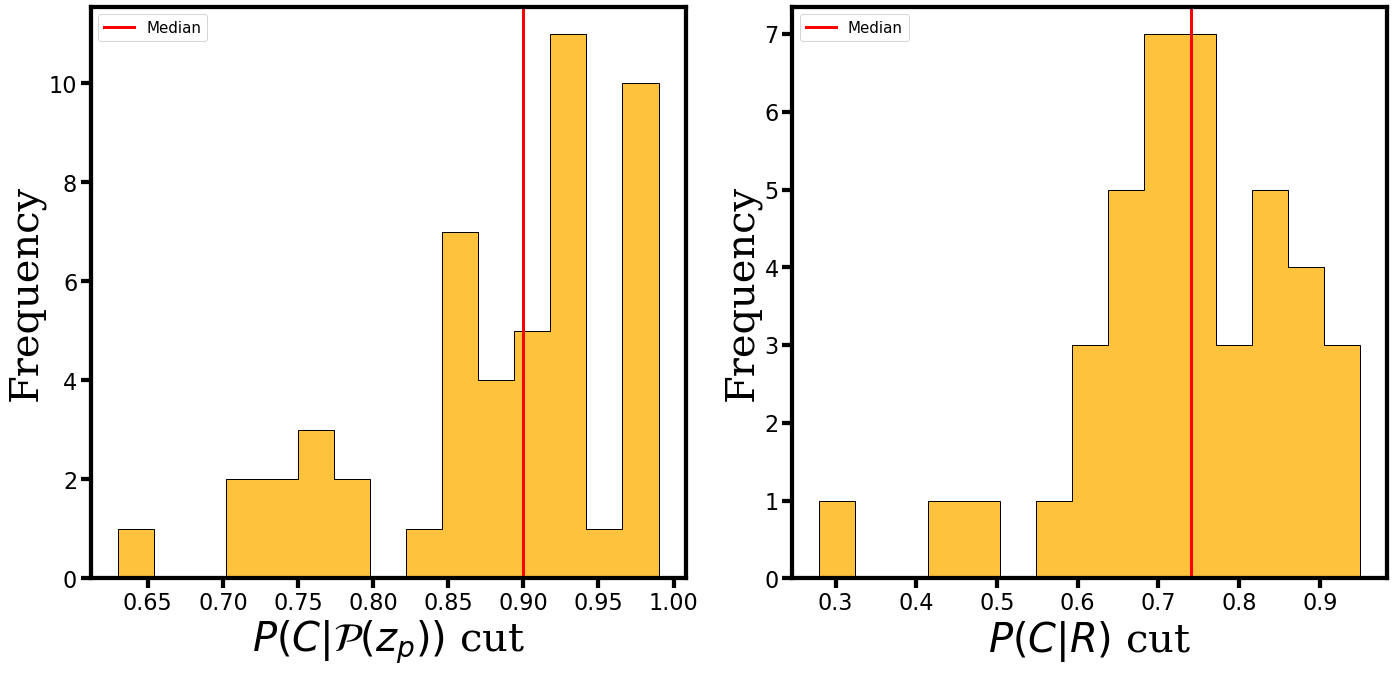

In [20]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(cut_zp_list[cut_zp_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$P(C|\mathcal{P}(z_p))$ cut", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(cut_R_list[cut_R_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax2.axvline(cut_R_median, color="red", lw=3, label="Median")
ax2.set_xlabel(r"$P(C|R)$ cut", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
ax2.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

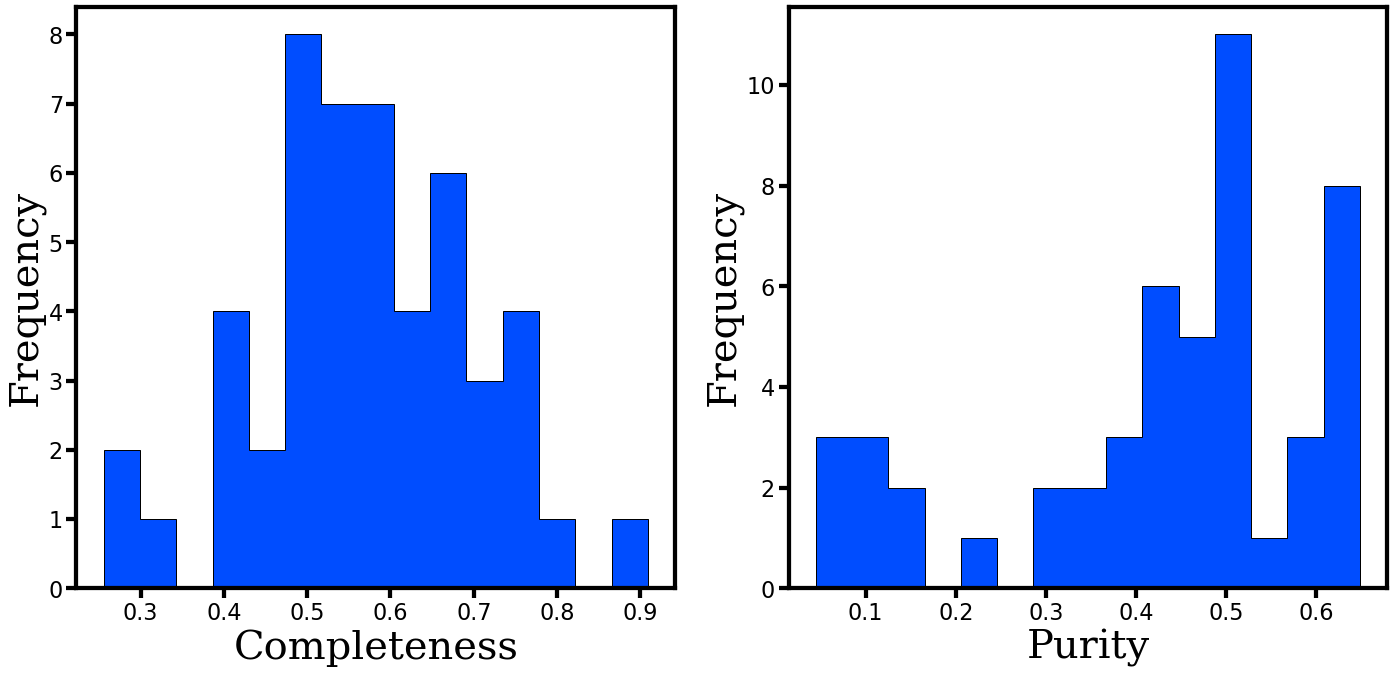

In [11]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

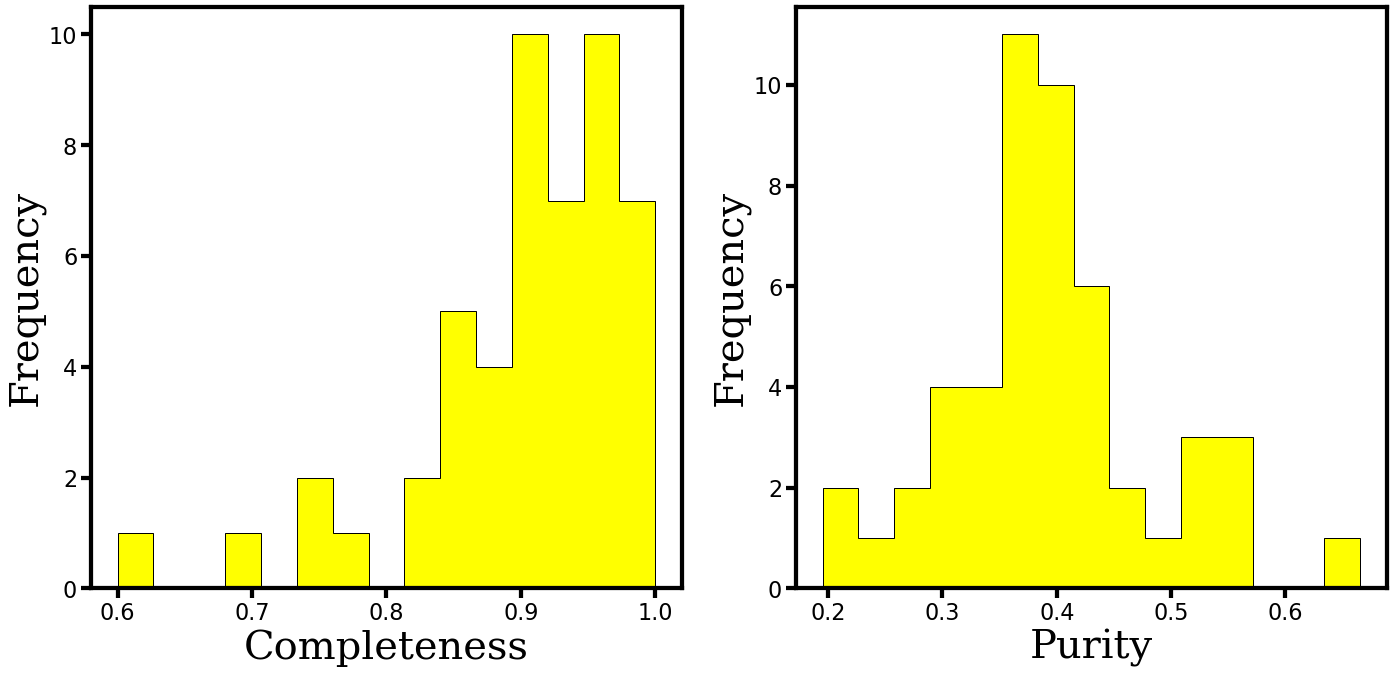

In [12]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

In [30]:
hdul = fits.open("cluster-mocks/lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

magr = scat["mag_r"]
mask_mag = magr < 21

haloId = scat["haloId"][mask_mag]
galaxyId = scat["galaxyId"][mask_mag]
z_phot_original = scat["z_phot"][mask_mag]
z_spec = scat["z_app"][mask_mag]
ra = scat["RA"][mask_mag]
dec = scat["DEC"][mask_mag]
magr = scat["mag_r"][mask_mag]
magu = scat["mag_u"][mask_mag]
magg = scat["mag_g"][mask_mag]
magi = scat["mag_i"][mask_mag]
magz = scat["mag_z"][mask_mag]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"][mask_mag]

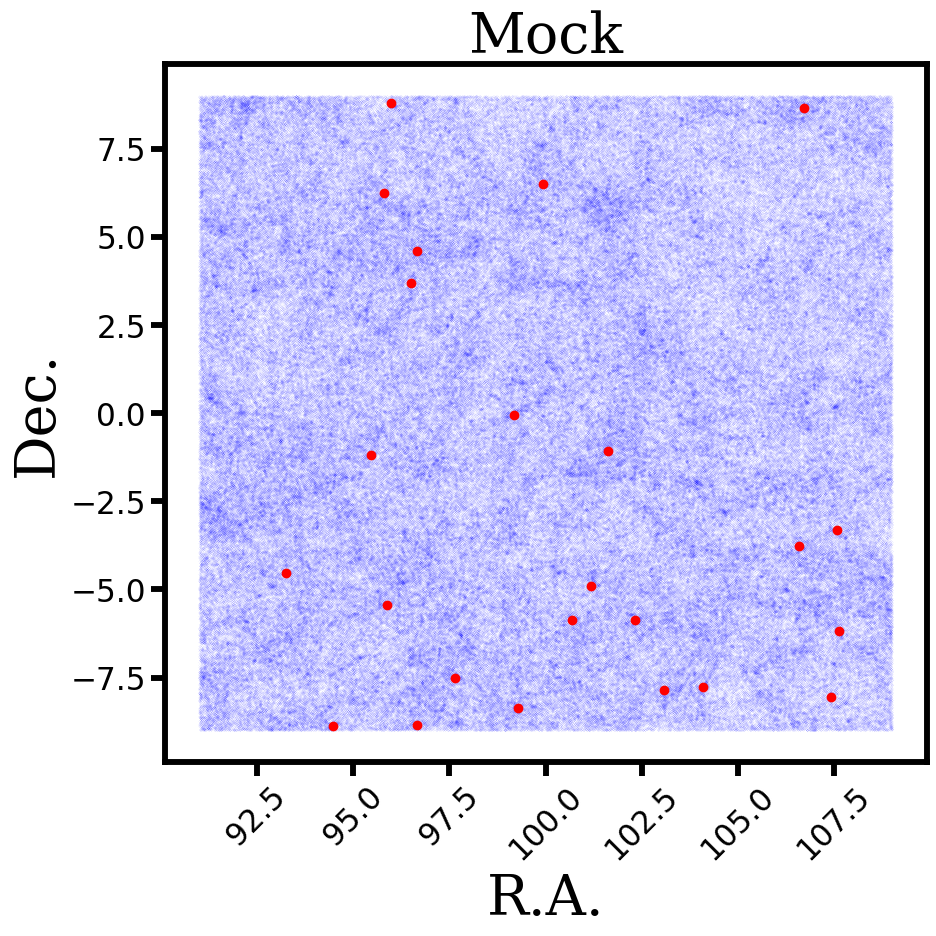

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.scatter(ra0_list, dec0_list, marker='o', color='red')
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

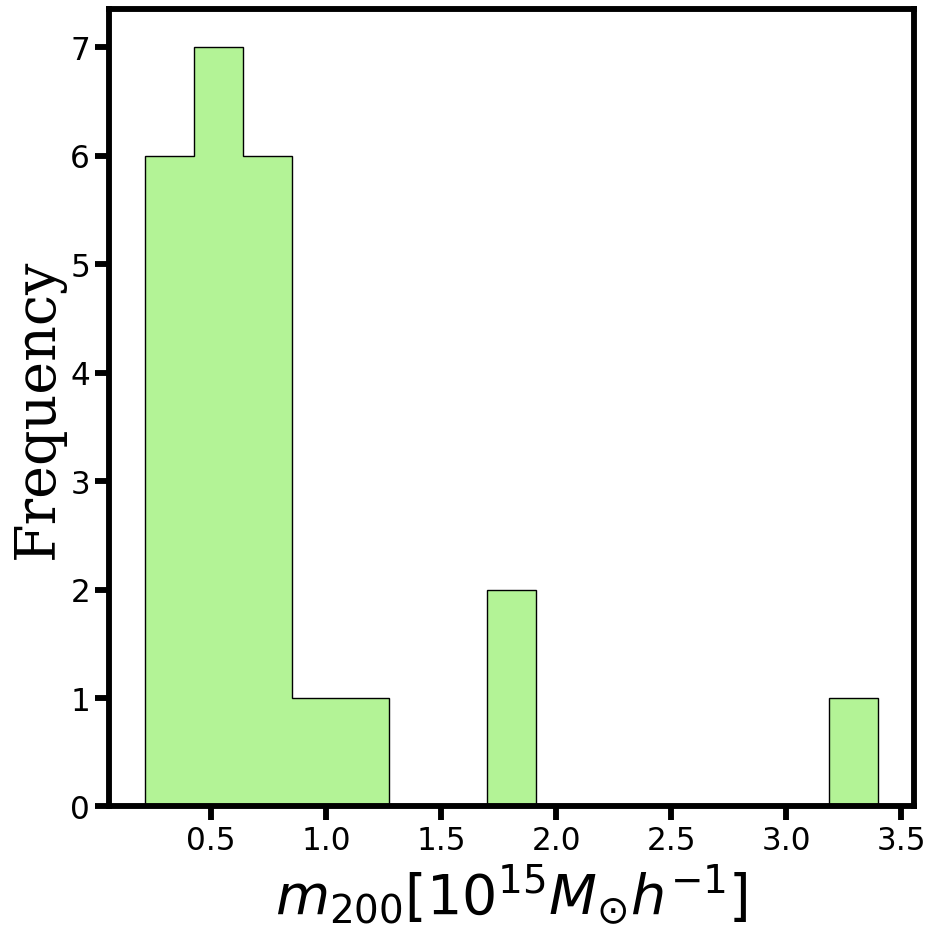

In [27]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(m200_list/1e15, bins=15, color=colors2[5], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$m_{200} [ 10^{15} M_{\odot} h^{-1}]$", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

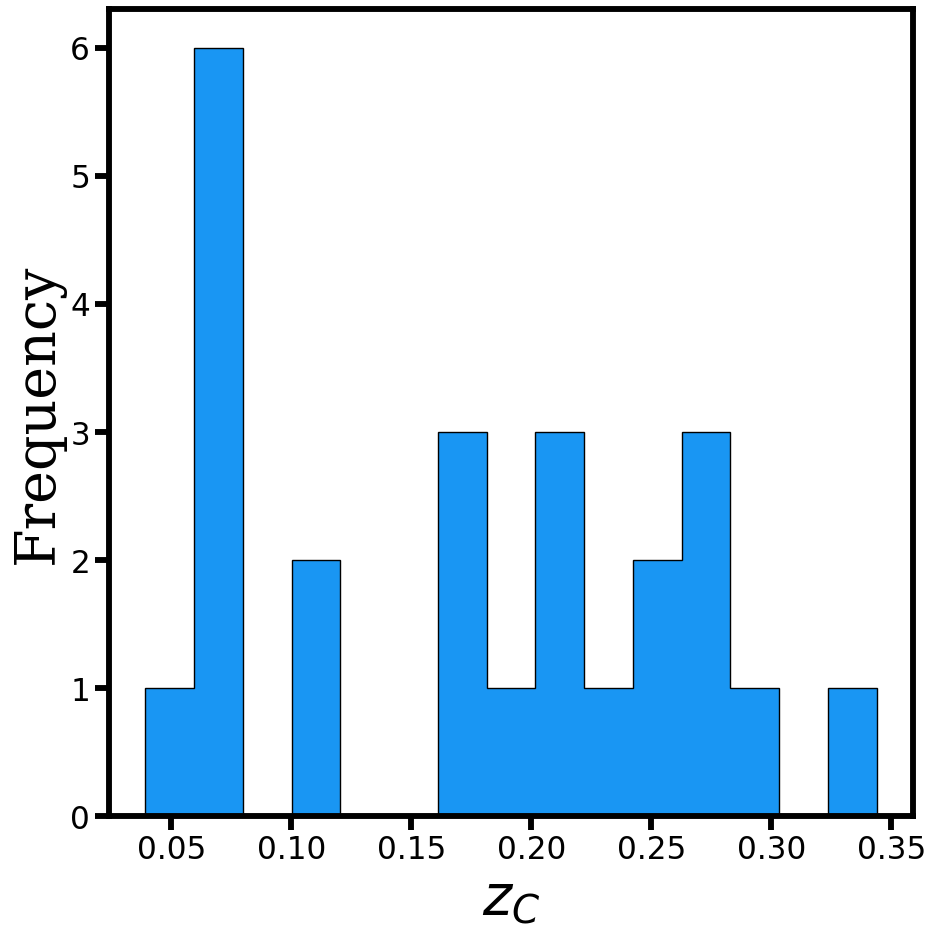

In [20]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(z_cluster_list, bins=15, color=colors2[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$z_C$", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

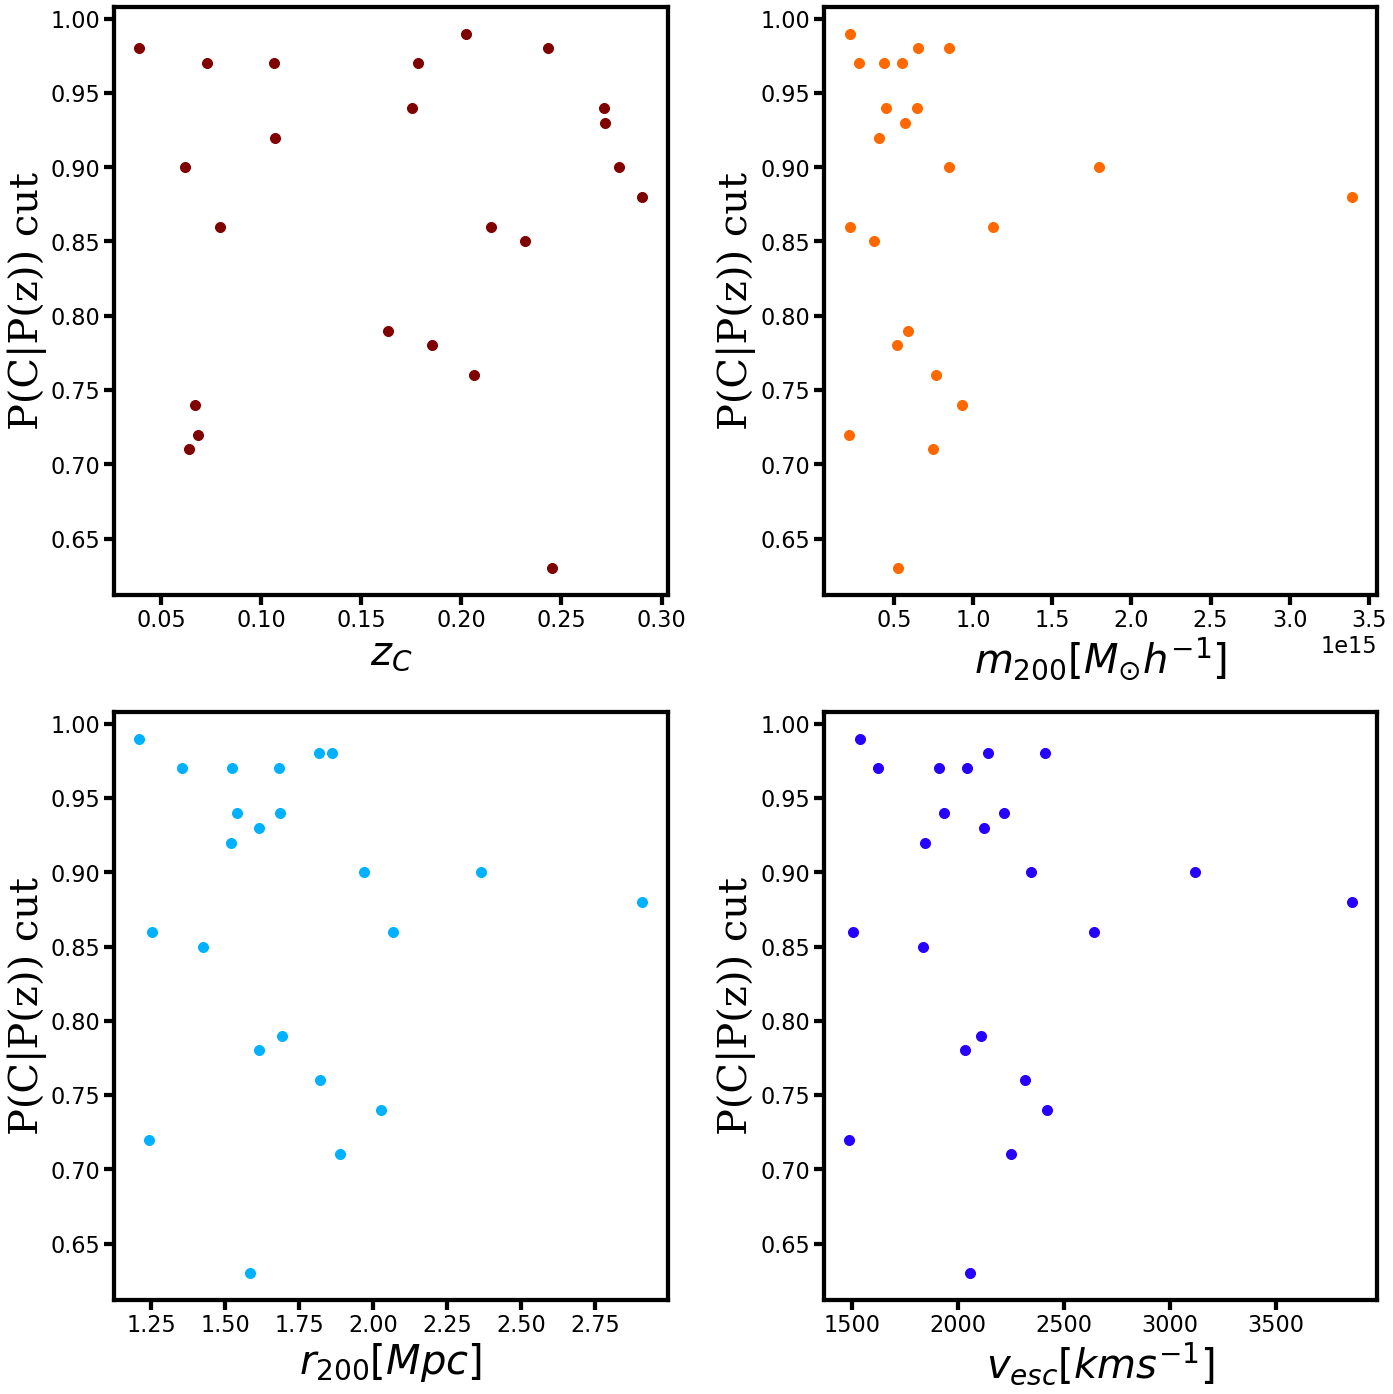

In [46]:
mask = cut_zp_list > 0.2

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
ax1.scatter(z_cluster_list[mask], cut_zp_list[mask], s=100, c=colors1[9])
ax1.set_xlabel(r"$z_C$", fontdict=font)
ax1.set_ylabel("P(C|P(z)) cut", fontdict=font)


ax2 = fig.add_subplot(222)
ax2.scatter(m200_list[mask], cut_zp_list[mask], s=100, c=colors1[7])
ax2.set_xlabel(r"$m_{200} [M_{\odot} h^{-1}]$", fontdict=font)
ax2.set_ylabel("P(C|P(z)) cut", fontdict=font)


ax3 = fig.add_subplot(223)
ax3.scatter(r200_mpc_list[mask], cut_zp_list[mask], s=100, c=colors1[2])
ax3.set_xlabel(r"$r_{200} [Mpc]$", fontdict=font)
ax3.set_ylabel("P(C|P(z)) cut", fontdict=font)


ax4 = fig.add_subplot(224)
ax4.scatter(v_esc[mask], cut_zp_list[mask], s=100, c=colors3[2])
ax4.set_xlabel(r"$v_{esc} [km s^{-1}]$", fontdict=font)
ax4.set_ylabel("P(C|P(z)) cut", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

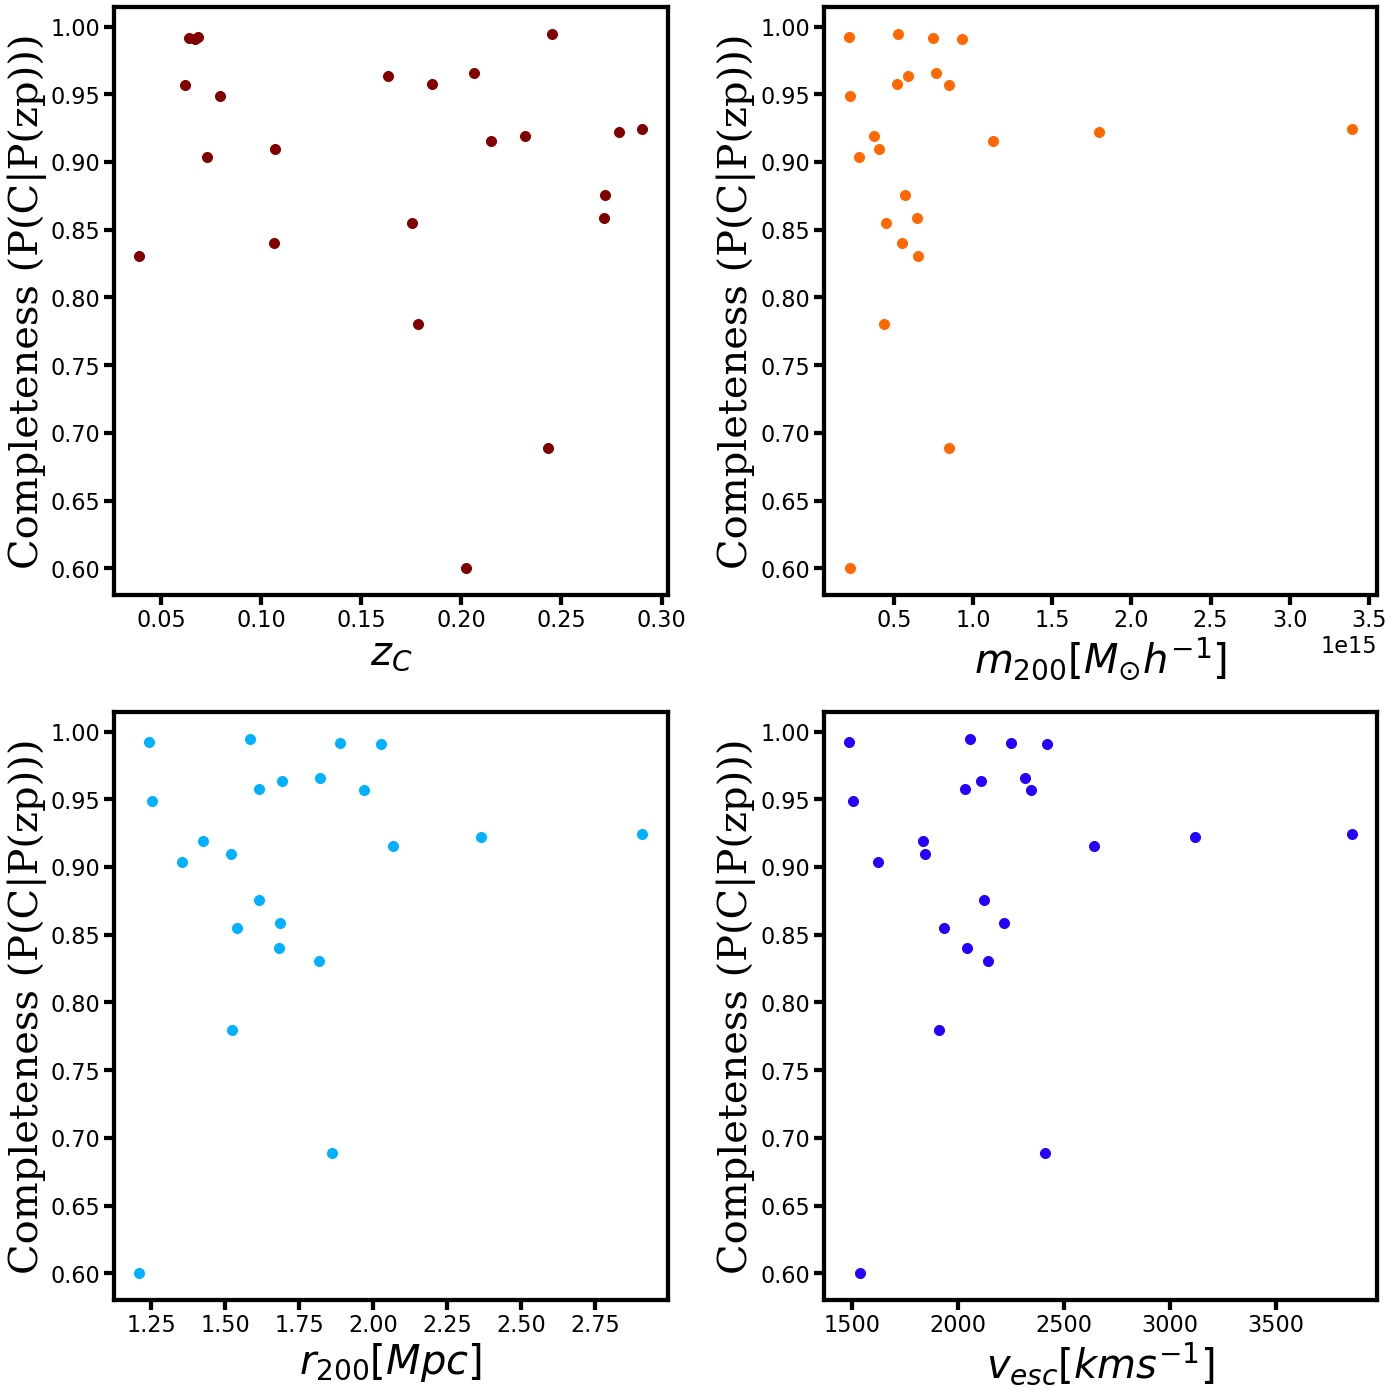

In [48]:
mask = cut_zp_list > 0.2

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
ax1.scatter(z_cluster_list[mask], c_zp_max_list[mask], s=100, c=colors1[9])
ax1.set_xlabel(r"$z_C$", fontdict=font)
ax1.set_ylabel("Completeness (P(C|P(zp)))", fontdict=font)


ax2 = fig.add_subplot(222)
ax2.scatter(m200_list[mask], c_zp_max_list[mask], s=100, c=colors1[7])
ax2.set_xlabel(r"$m_{200} [M_{\odot} h^{-1}]$", fontdict=font)
ax2.set_ylabel("Completeness (P(C|P(zp)))", fontdict=font)


ax3 = fig.add_subplot(223)
ax3.scatter(r200_mpc_list[mask], c_zp_max_list[mask], s=100, c=colors1[2])
ax3.set_xlabel(r"$r_{200} [Mpc]$", fontdict=font)
ax3.set_ylabel("Completeness (P(C|P(zp)))", fontdict=font)


ax4 = fig.add_subplot(224)
ax4.scatter(v_esc[mask], c_zp_max_list[mask], s=100, c=colors3[2])
ax4.set_xlabel(r"$v_{esc} [km s^{-1}]$", fontdict=font)
ax4.set_ylabel("Completeness (P(C|P(zp)))", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

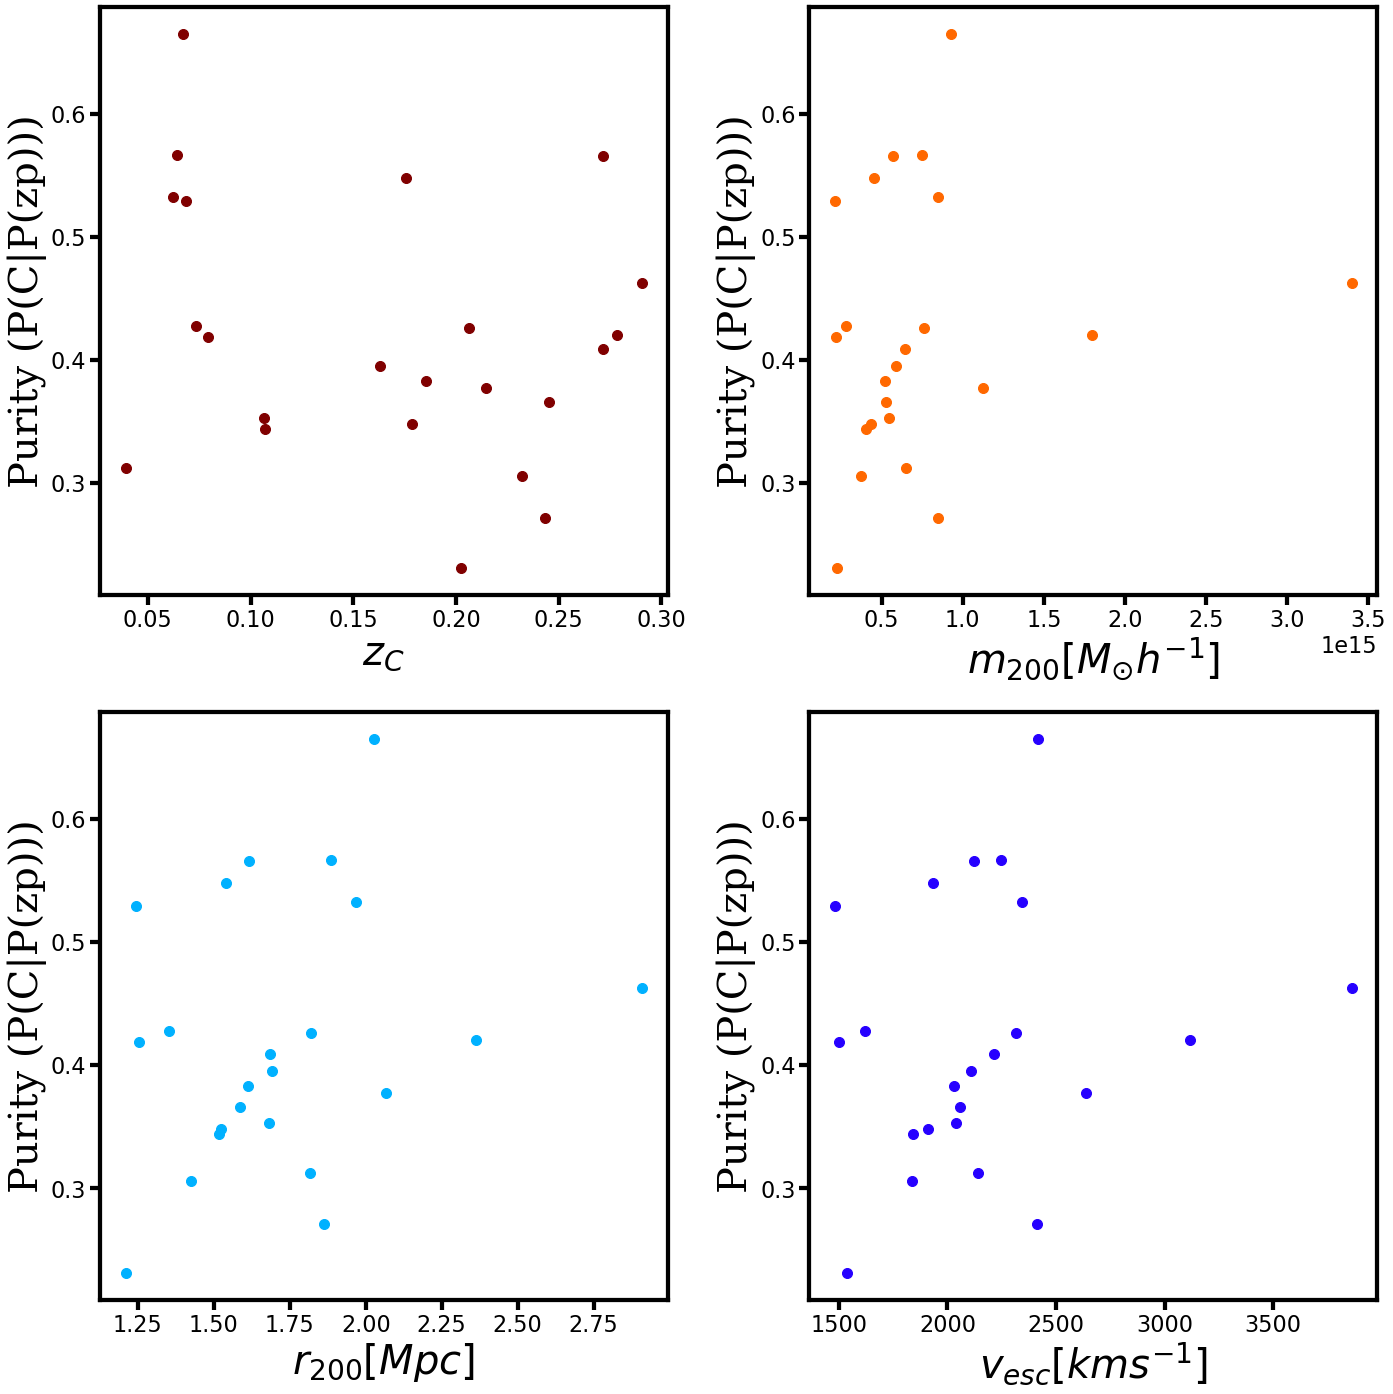

In [49]:
mask = cut_zp_list > 0.2

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
ax1.scatter(z_cluster_list[mask], p_zp_max_list[mask], s=100, c=colors1[9])
ax1.set_xlabel(r"$z_C$", fontdict=font)
ax1.set_ylabel("Purity (P(C|P(zp)))", fontdict=font)


ax2 = fig.add_subplot(222)
ax2.scatter(m200_list[mask], p_zp_max_list[mask], s=100, c=colors1[7])
ax2.set_xlabel(r"$m_{200} [M_{\odot} h^{-1}]$", fontdict=font)
ax2.set_ylabel("Purity (P(C|P(zp)))", fontdict=font)


ax3 = fig.add_subplot(223)
ax3.scatter(r200_mpc_list[mask], p_zp_max_list[mask], s=100, c=colors1[2])
ax3.set_xlabel(r"$r_{200} [Mpc]$", fontdict=font)
ax3.set_ylabel("Purity (P(C|P(zp)))", fontdict=font)


ax4 = fig.add_subplot(224)
ax4.scatter(v_esc[mask], p_zp_max_list[mask], s=100, c=colors3[2])
ax4.set_xlabel(r"$v_{esc} [km s^{-1}]$", fontdict=font)
ax4.set_ylabel("Purity (P(C|P(zp)))", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


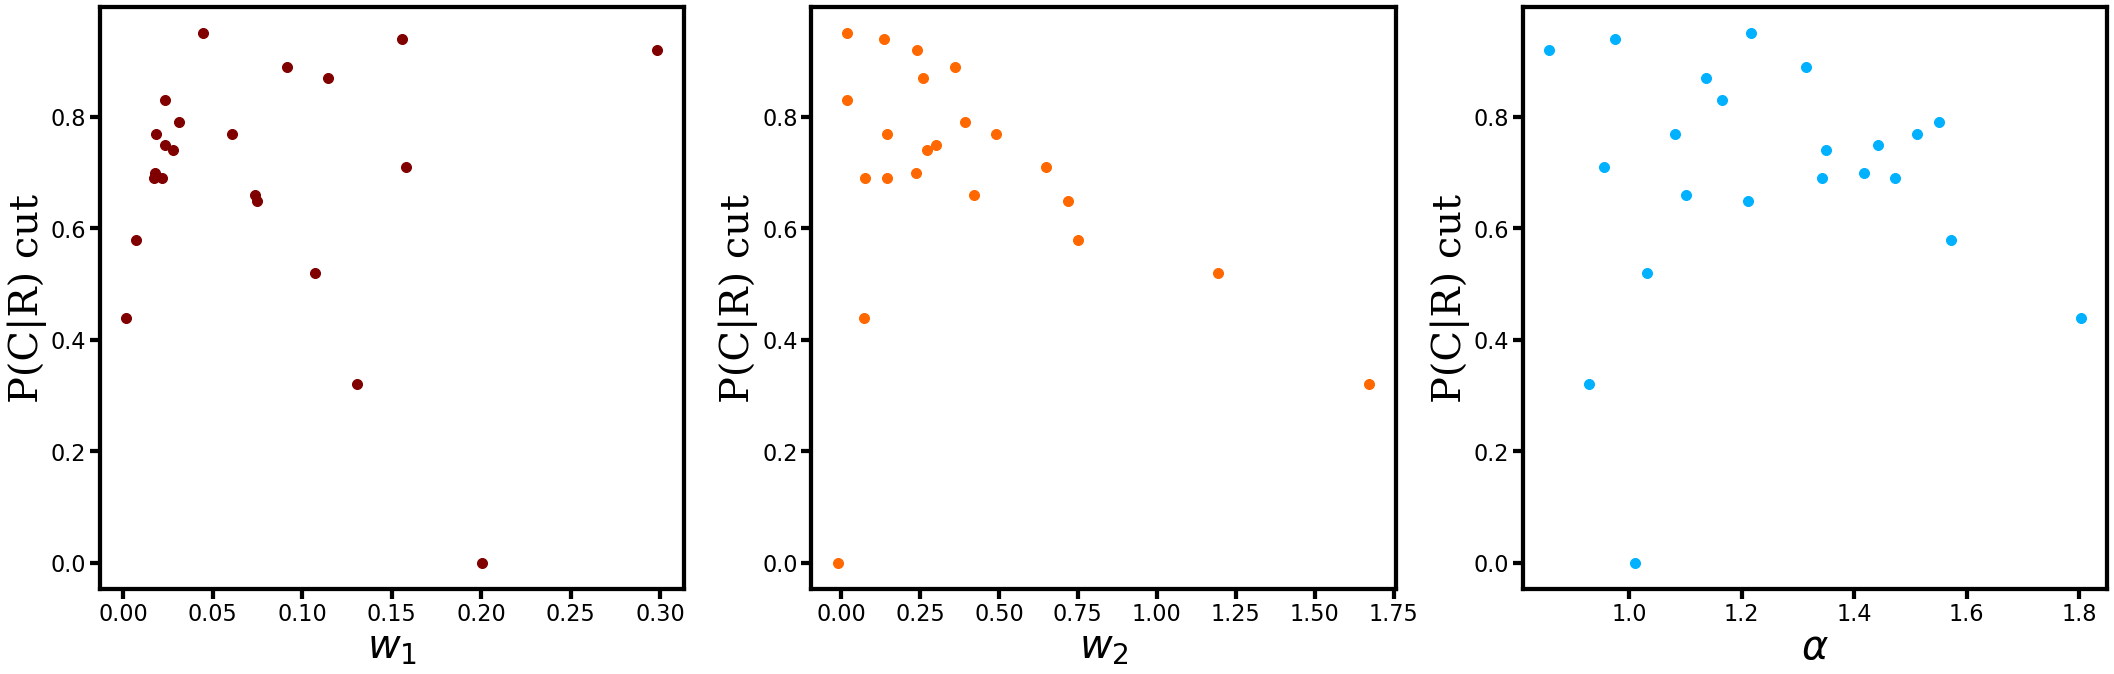

In [30]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(131)
ax1.scatter(w1_list, cut_R_list, s=100, c=colors1[9])
ax1.set_xlabel(r"$w_1$", fontdict=font)
ax1.set_ylabel("P(C|R) cut", fontdict=font)


ax2 = fig.add_subplot(132)
ax2.scatter(w2_list, cut_R_list, s=100, c=colors1[7])
ax2.set_xlabel(r"$w_2$", fontdict=font)
ax2.set_ylabel("P(C|R) cut", fontdict=font)



ax3 = fig.add_subplot(133)
ax3.scatter(alpha_list, cut_R_list, s=100, c=colors1[2])
ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel("P(C|R) cut", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


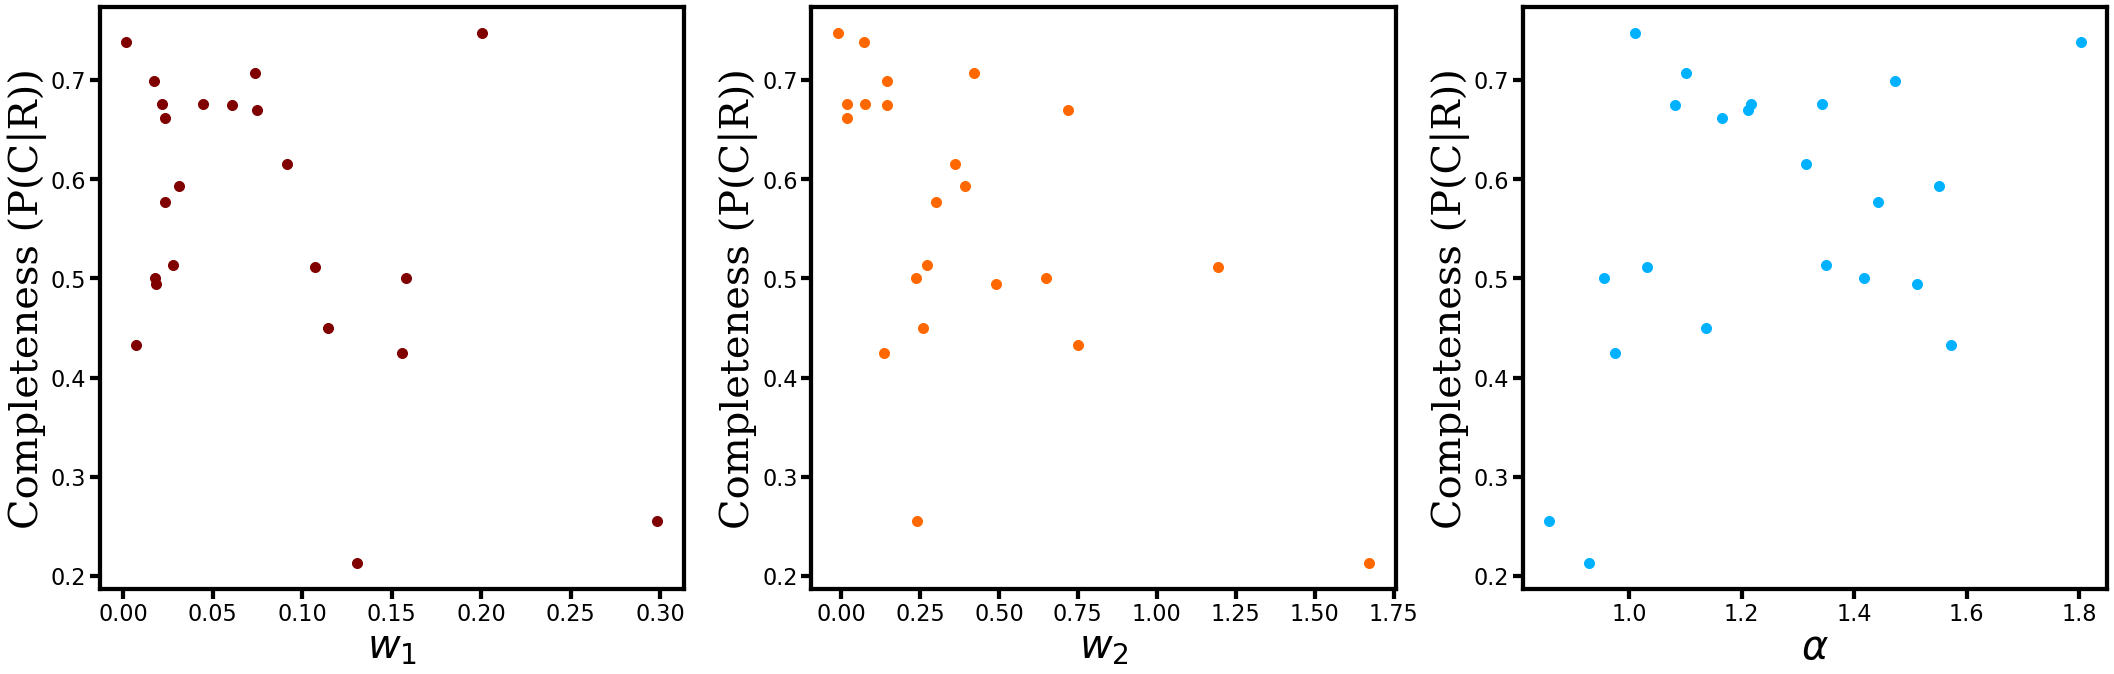

In [31]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(131)
ax1.scatter(w1_list, c_R_max_list, s=100, c=colors1[9])
ax1.set_xlabel(r"$w_1$", fontdict=font)
ax1.set_ylabel("Completeness (P(C|R))", fontdict=font)


ax2 = fig.add_subplot(132)
ax2.scatter(w2_list, c_R_max_list, s=100, c=colors1[7])
ax2.set_xlabel(r"$w_2$", fontdict=font)
ax2.set_ylabel("Completeness (P(C|R))", fontdict=font)


ax3 = fig.add_subplot(133)
ax3.scatter(alpha_list, c_R_max_list, s=100, c=colors1[2])
ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel("Completeness (P(C|R))", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


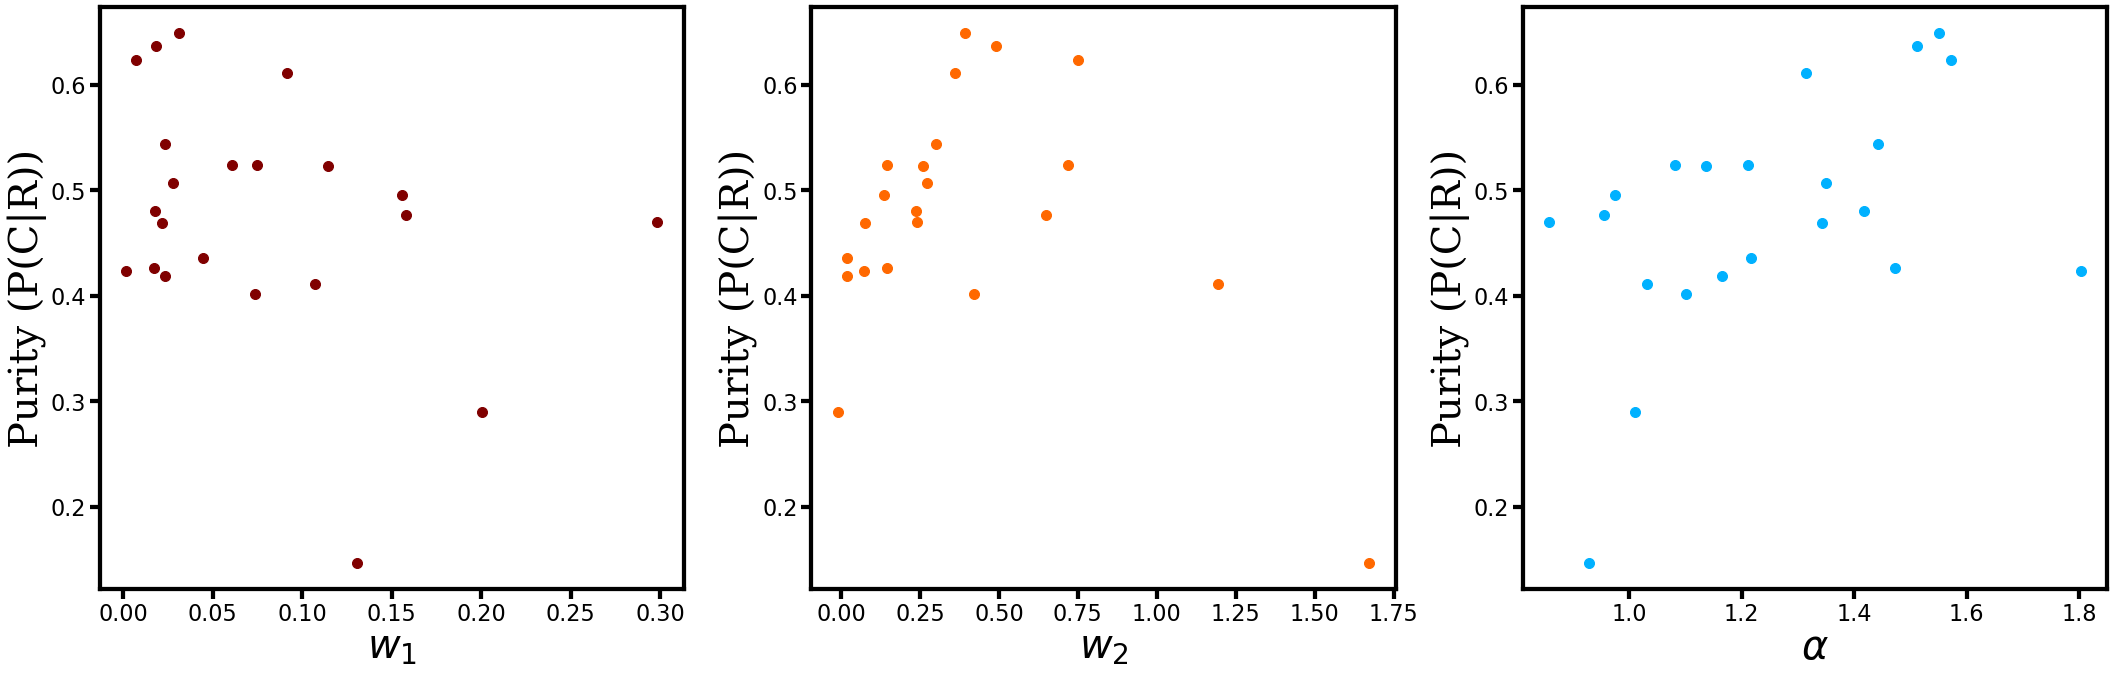

In [32]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(131)
ax1.scatter(w1_list, p_R_max_list, s=100, c=colors1[9])
ax1.set_xlabel(r"$w_1$", fontdict=font)
ax1.set_ylabel("Purity (P(C|R))", fontdict=font)


ax2 = fig.add_subplot(132)
ax2.scatter(w2_list, p_R_max_list, s=100, c=colors1[7])
ax2.set_xlabel(r"$w_2$", fontdict=font)
ax2.set_ylabel("Purity (P(C|R))", fontdict=font)


ax3 = fig.add_subplot(133)
ax3.scatter(alpha_list, p_R_max_list, s=100, c=colors1[2])
ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel("Purity (P(C|R))", fontdict=font)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')